#Part-B [15 points]: Multiclass App Review Classification: from scratch

Dataset analysis and report on important statistics.

Implement a from-scratch model
o (RNN-based model: LSTM/GRU/Bidirectional/stacked/…)

Train the word embeddings from scratch

Use precomputed embeddings (similar to word2vec or Glove for Arabic)

Classification analysis and possible improvements.

#Part-C [15 points]: Multilabel App Review Classification: from scratch

Dataset analysis and report on important statistics.

Implement a from-scratch model
o (RNN-based model: LSTM/GRU/Bidirectional/stacked/…)

You can use the best embedding from Part-B

Classification analysis and possible improvements.

#Part-D [15 points]: Multiclass App Review Classification: Finetune an MLM


Fine-tune a Bert-type model like Arabert or Marbert

Classification analysis and possible improvements.

#Part-E [15 points]: Multilabel App Review Classification: Finetune an MLM

Fine-tune a Bert-type model like Arabert or Marbert

Classification analysis and possible improvements.

#Part-F [15 points]: Multiclass App Review Classification: In-Context learning using causal LLM

Use a causal LLM like GPT or DeepSeek

Zero-shot learning: Design an effective prompt for the task.

o Show the process on multiple prompts by evaluating them on randomly selected 100 samples from the validation set.

o Design the prompts in English and Arabic and compare their performance.

o Select the best prompt design.

o [BONUS] Study the impact of ideas such as informing the model about the
class distribution (based on training data), chain-of-thought, etc.


Few-shot learning: Perform few-shot learning by designing an effective prompt
for the task:

o Select different number of demonstration examples from the training set
and evaluate the performance on the validation set. Plot the performance to
select the best configuration.

o [BONUS] Random demonstration examples vs. selecting demonstration
examples based on some criteria such as similarity and class labels.

o [BONUS] Study the impact of ideas such as ordering of demonstration
based on some criteria vs. random ordering.


#Part-G [15 points]: Multilabel App Review Classification: In-Context learning using causal LLM


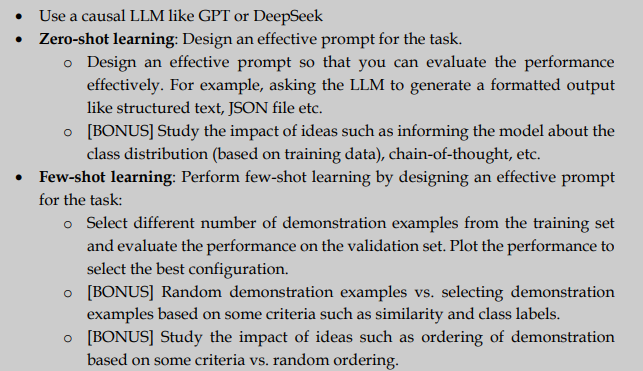